# **Project: Machine Failure Classification using Sensor Data**
## Pendahuluan

Proyek ini bertujuan untuk membangun sistem _predictive maintenance_ yang dapat mengklasifikasikan jenis kegagalan mesin (_failure type_) berdasarkan data sensor. Dataset yang digunakan adalah **AI4I 2020 Predictive Maintenance Dataset**, yang berisi parameter sensor seperti suhu, kecepatan rotasi, torsi, dan lama pemakaian alat.\
Hasil akhir dari proyek ini berupa:
1. Model machine learning (Random Forest/Logistic Regression/XGBoost).
2. Web app interaktif berbasis Streamlit untuk melakukan prediksi secara real-time maupun batch (CSV).

#
## Import library
Menggunakan pustaka Python populer:
1. `pandas`, `numpy` → manipulasi data
2. `scikit-learn` → preprocessing & training model
3. `imbalanced-learn` (SMOTE) → menangani data imbalance
4. `matplotlib`,`seaborn` → visualisasi

In [2]:
import copy
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_selection import mutual_info_classif
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline

import joblib

#
## Data Loading & Exploration

In [1]:
data = pd.read_csv("ai4i2020.csv")
data.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


**Jenis-jenis Failure (sub-label)**
1. TWF (Tool Wear Failure) → failure karena keausan alat.
2. HDF (Heat Dissipation Failure) → failure karena masalah pendinginan / pembuangan panas.
3. PWF (Power Failure) → failure karena suplai daya.
4. OSF (Overstrain Failure) → failure karena beban berlebih.
5. RNF (Random Failures) → failure acak (tidak spesifik).

#


In [3]:
data.describe()

,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
mean,5000.50000,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900,0.004600,0.011500,0.009500,0.009800,0.00190
std,2886.89568,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981,0.067671,0.106625,0.097009,0.098514,0.04355
min,1.00000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,2500.75000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,5000.50000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,7500.25000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,10000.00000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


**Kesimpulan Statistik Utama:**
1. Fitur suhu (Air & Process Temperature) sangat stabil, dilihat dari std→ bukan faktor utama variasi.
2. Rotational speed, Torque, dan Tool wear memiliki variasi lebih besar → kemungkinan lebih berpengaruh terhadap kegagalan.
3. Machine failure sangat jarang terjadi (3.4%) → problem klasifikasi ini highly imbalanced.
4. Jenis kegagalan juga imbalanced → beberapa tipe sangat jarang muncul.
#

In [4]:
features  = data.select_dtypes(include=['int64', 'float64'])
features = features.columns
features = features.drop(['UDI','Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'])
features

Index(['Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]'],
      dtype='object')

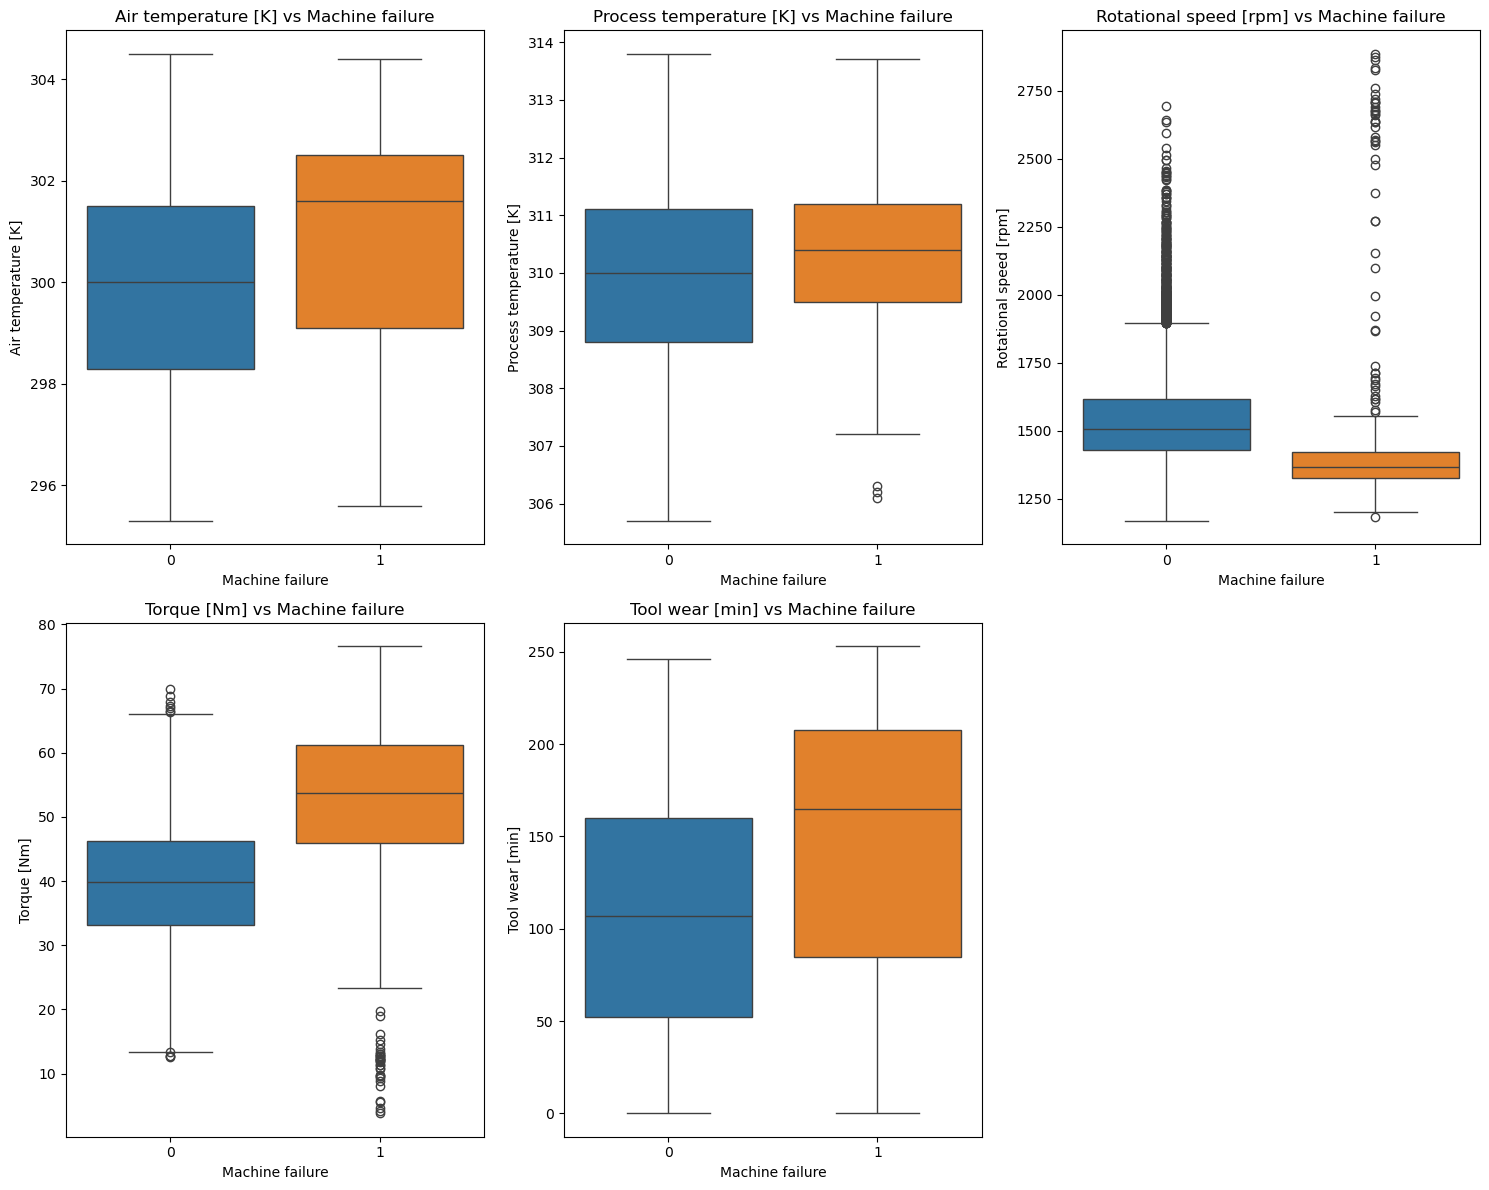

In [5]:
plt.figure(figsize=(15, 12))
for i, col in enumerate(features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(data=data,
        x="Machine failure",
        y=col,
        hue="Machine failure",
        dodge=False,
        legend=False)
    plt.title(f"{col} vs Machine failure")

plt.tight_layout()
plt.show()

**Kesimpulan awal**
1. Fitur paling kuat terhadap failure:\
`Torque [Nm]` dan `Tool wear [min]`
2. Fitur dengan kontribusi tambahan:\
`Process temperature` dan `Rotational speed`
3. Fitur lemah / tidak relevan:\
`Air temperature` (hanya korelasi lemah).

#

In [6]:
features  = data.select_dtypes(include=['int64', 'float64'])
features = features.columns
features = features.drop(['UDI'])
features

Index(['Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]',
       'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'],
      dtype='object')

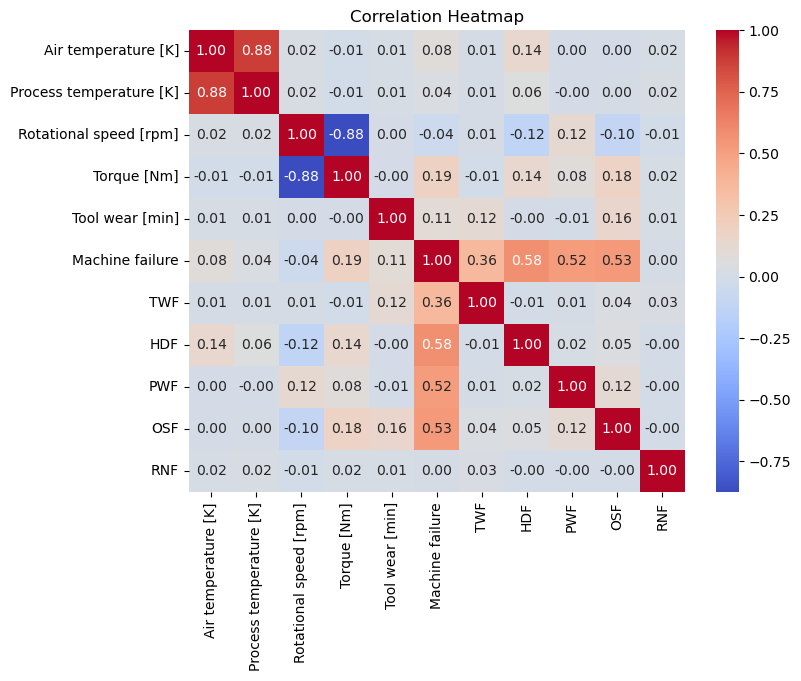

In [7]:
plt.figure(figsize=(8,6))
corr = data[features].select_dtypes(include=['float64', 'int64']).corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

**Kesimpulan Utama**
1. Faktor operasional penting: Torque & Tool wear.
2. Multikolinearitas: Air temp vs Process temp, Torque vs Rotational speed → perlu hati-hati saat modeling.
3. Jenis failure paling berhubungan: HDF, PWF, OSF → bisa jadi fokus analisis lebih lanjut.

#

In [8]:
features  = data.select_dtypes(include=['int64', 'float64'])
features = features.columns
features = features.drop(['UDI','Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'])
features

Index(['Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]'],
      dtype='object')

In [9]:
X = data[features]
y = data['Machine failure'].astype(int)

mi = mutual_info_classif(X, y, random_state=42)
mi_scores = list(zip(X.columns, mi))
mi_scores_sorted = sorted(mi_scores, key=lambda x: x[1], reverse=True)

for col, score in mi_scores_sorted:
    print(f"{col}: {score:.4f}")


Torque [Nm]: 0.0471
Rotational speed [rpm]: 0.0358
Tool wear [min]: 0.0096
Air temperature [K]: 0.0075
Process temperature [K]: 0.0046


**Kesimpulan**
* Fokus utama model: Torque dan Rotational speed.
* Faktor pendukung: Tool wear, Air temp.
* Kurang relevan: Process temperature (mungkin bisa di-drop untuk mengurangi noise).

#
Doing some experiment here

In [10]:
data_power = data.copy()
data_power["power"] = data_power["Torque [Nm]"] * data_power["Rotational speed [rpm]"]
data_power.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF,power
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0,66382.8
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0,65190.4
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0,74001.2
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0,56603.5
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0,56320.0


In [11]:
features  = data_power.select_dtypes(include=['int64', 'float64'])
features = features.columns
features = features.drop(['UDI'])
features

Index(['Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]',
       'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF', 'power'],
      dtype='object')

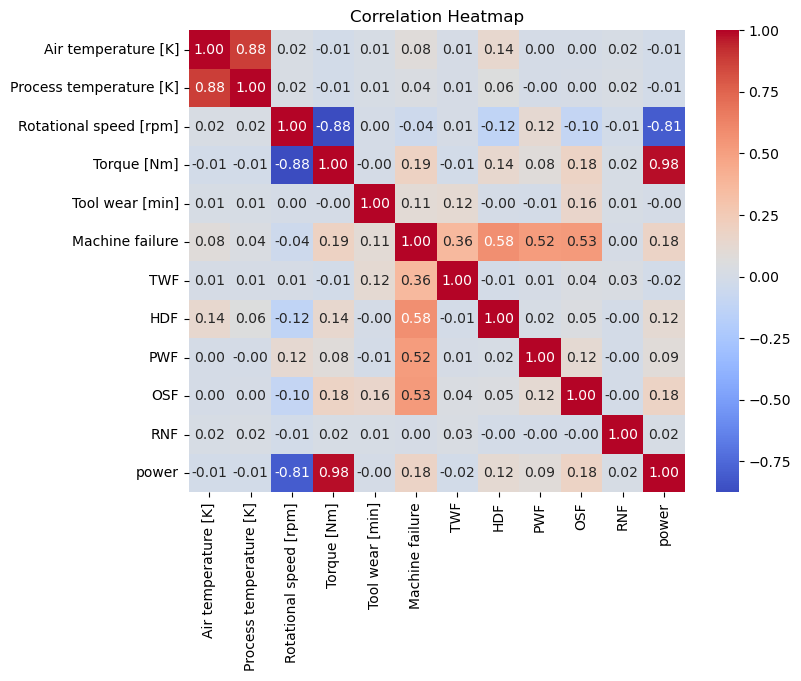

In [12]:
plt.figure(figsize=(8,6))
corr = data_power[features].select_dtypes(include=['float64', 'int64']).corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

I engineered a new feature `Power = Torque × RPM` However, correlation analysis shows strong redundancy with Torque and RPM (r > 0.8), so I dont think it would be nice to the model, and I decide to not using it on the model
#

## Feature Engineering
1. Seleksi fitur numerik: Air temperature, Process temperature, Rotational speed, Torque, Tool wear.
2. Membuat label target Failure_Type berdasarkan 5 kategori:
   * No Failure = `0`
   * TWF (Tool Wear Failure) = `1`
   * HDF (Heat Dissipation Failure) = `2`
   * PWF (Power Failure) = `3`
   * OSF (Overstrain Failure) = `4`
   * RNF (Random Failure) = `5`

In [13]:
def map_failure(row):
    if row["TWF"] == 1: 
        return 1
    elif row["HDF"] == 1: 
        return 2
    elif row["PWF"] == 1: 
        return 3
    elif row["OSF"] == 1: 
        return 4
    elif row["RNF"] == 1: 
        return 5
    else:
        return 0   # No Failure

data["Failure_Type"] = data.apply(map_failure, axis=1)

In [14]:
print(data["Failure_Type"].value_counts())

Failure_Type
0    9652
2     115
3      91
4      78
1      46
5      18
Name: count, dtype: int64


#
> The dataset is highly imbalanced We want to balance the labels without removing any data points, because the dataset is already relatively small and we don't want to lose information.
#

In [15]:
features  = data.select_dtypes(include=['int64', 'float64'])
features = features.columns
features = features.drop(['UDI', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'])
features

Index(['Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]',
       'Machine failure', 'Failure_Type'],
      dtype='object')

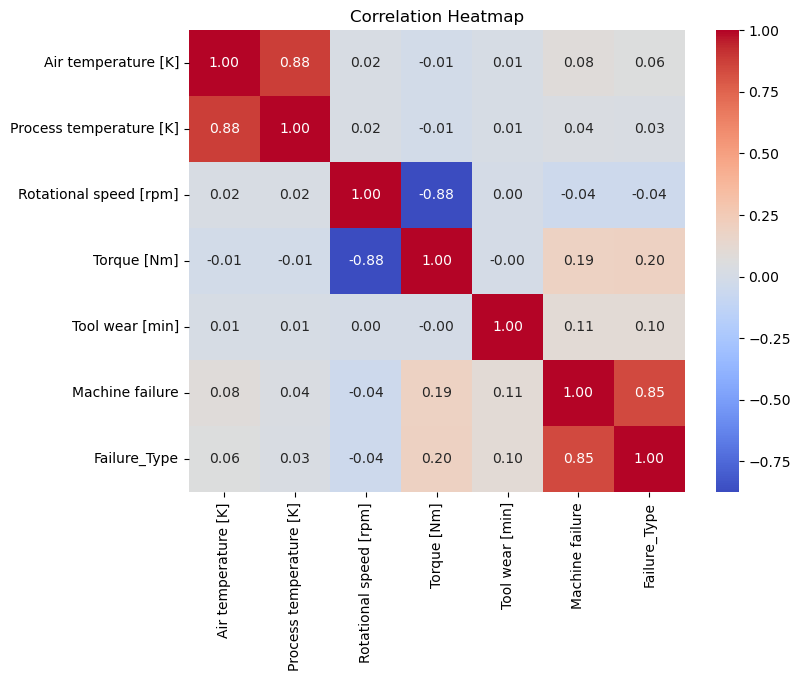

In [16]:
plt.figure(figsize=(8,6))
corr = data[features].select_dtypes(include=['float64', 'int64']).corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

#
## Preparing and choosing the Baseline Model
#### Handling Imbalanced Data
Menggunakan SMOTE (Synthetic Minority Over-sampling Technique) untuk menyeimbangkan distribusi kelas.

In [17]:
features = features.drop(['Machine failure', 'Failure_Type'])
features

Index(['Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]'],
      dtype='object')

In [18]:
X = data[features]
y = data["Failure_Type"]

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42, stratify=y)

#
### 1st Model : Logistic Regression
Logistic Regression is often used as a baseline model for classification tasks.\
Because it is inherently linear, it might not be able to capture the non-linear relationships in our dataset.\
To make it more expressive, we could add polynomial features or transform the input space so that the model can approximate non-linear patterns.

In [33]:
pipe_log = Pipeline([
    ('standarize', StandardScaler()),
    ('smote', SMOTE(random_state=42, k_neighbors=3)),
    ('log_reg', LogisticRegression( solver="lbfgs", max_iter=2000))
])
pipe_log.fit(X_train, y_train)
y_pred_log = pipe_log.predict(X_test)


              precision    recall  f1-score   support

           0      0.998     0.633     0.774      1930
           1      0.059     0.889     0.110         9
           2      0.286     0.957     0.440        23
           3      0.500     0.889     0.640        18
           4      0.381     1.000     0.552        16
           5      0.002     0.250     0.004         4

    accuracy                          0.642      2000
   macro avg      0.371     0.769     0.420      2000
weighted avg      0.974     0.642     0.763      2000



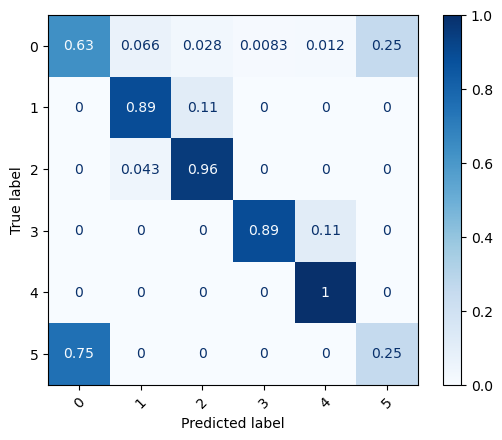

In [34]:
classes = np.unique(y_train)

cm = confusion_matrix(y_test, y_pred_log, labels=classes, normalize='true')
disp = ConfusionMatrixDisplay(cm, display_labels=classes)
disp.plot(cmap='Blues', xticks_rotation=45)
print(classification_report(y_test, y_pred_log, digits=3, zero_division=0))

**Kesimpulan Utama**
* Logistic Regression sebagai baseline tidak cukup kuat untuk dataset imbalanced seperti ini.
* Model cenderung bias ke kelas mayoritas, menyebabkan performa buruk pada kelas minoritas (khususnya RNF).
* Meskipun recall tinggi pada beberapa kelas (misalnya TWF, OSF), precisionnya sangat buruk → artinya model sering salah alarm.

#
### 2nd model : Random Forest 
Metode yang membuat banyak pohon keputusan lalu mengambil suara terbanyak.\
Sederhana, kuat, dan biasanya cukup akurat tanpa banyak pengaturan.

In [35]:
pipe_rf = Pipeline([
    ('standarize', StandardScaler()),
    ('smote', SMOTE(random_state=42, k_neighbors=3)),
    ('rf', RandomForestClassifier(n_estimators=400, random_state=42))
])
pipe_rf.fit(X_train, y_train)
y_pred_rf = pipe_rf.predict(X_test)


              precision    recall  f1-score   support

           0      0.991     0.981     0.986      1930
           1      0.067     0.111     0.083         9
           2      0.731     0.826     0.776        23
           3      0.824     0.778     0.800        18
           4      0.696     1.000     0.821        16
           5      0.000     0.000     0.000         4

    accuracy                          0.972      2000
   macro avg      0.551     0.616     0.578      2000
weighted avg      0.978     0.972     0.974      2000



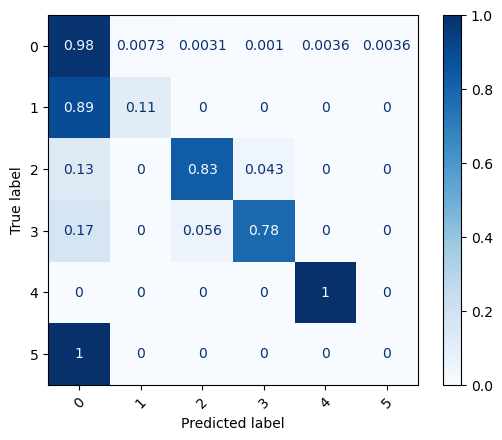

In [36]:
classes = np.unique(y_train)

cm = confusion_matrix(y_test, y_pred_rf, labels=classes, normalize='true')
disp = ConfusionMatrixDisplay(cm, display_labels=classes)
disp.plot(cmap='Blues', xticks_rotation=45)
print(classification_report(y_test, y_pred_rf, digits=3, zero_division=0))

**Kesimpulan Utama**
* Random Forest jauh lebih baik dibanding Logistic Regression pada dataset ini karena mampu menangkap pola kompleks, menghasilkan akurasi tinggi, dan performa bagus di kelas mayoritas maupun sebagian kelas minoritas.
* Namun, kelas sangat kecil (TWF & RNF) masih sulit dipelajari → RF masih bias terhadap kelas mayoritas.
* Model ini bisa menjadi baseline yang kuat, tapi perlu tambahan teknik seperti:
  * Oversampling untuk memperbaiki representasi kelas minoritas,
  * atau ensemble methods dengan fokus pada kelas kecil.

#
## 3th Model : XGBoost
Metode yang membuat pohon keputusan satu per satu, tiap pohon memperbaiki kesalahan pohon sebelumnya.
➡️ Lebih pintar dan biasanya lebih akurat, tapi butuh pengaturan lebih hati-hati.

In [38]:
cls_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
wmap = dict(zip(classes, cls_weights))
w_train = y_train.map(wmap).values  

wmap

{0: 0.172666839333506,
 1: 36.03603603603604,
 2: 14.492753623188406,
 3: 18.264840182648403,
 4: 21.50537634408602,
 5: 95.23809523809524}

In [44]:
xgb = XGBClassifier(
    objective="multi:softprob",
    num_class=len(classes),
    n_estimators=800,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    gamma=0.0,
    random_state=42,
    n_jobs=-1,
    tree_method="hist"   
)

xgb.fit(
    X_train.values, y_train,
    sample_weight=w_train,          
    eval_set=[(X_test.values, y_test)],    
    verbose=False
)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=0.0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=800,
              n_jobs=-1, num_class=6, ...)

In [47]:
y_pred_xg = xgb.predict(X_test)
print(classification_report(y_test, y_pred_xg, digits=3, zero_division=0))

              precision    recall  f1-score   support

           0      0.993     0.989     0.991      1930
           1      0.222     0.222     0.222         9
           2      0.786     0.957     0.863        23
           3      0.800     0.889     0.842        18
           4      0.737     0.875     0.800        16
           5      0.000     0.000     0.000         4

    accuracy                          0.981      2000
   macro avg      0.590     0.655     0.620      2000
weighted avg      0.981     0.981     0.981      2000



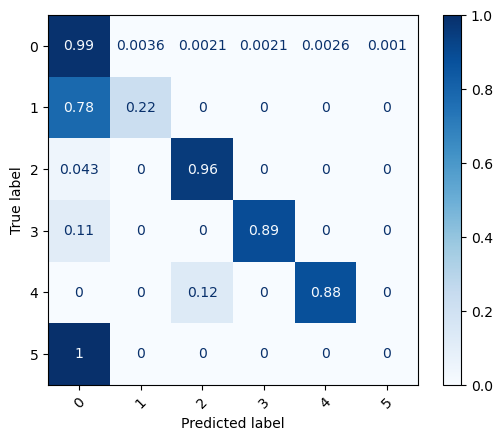

In [48]:
cm = confusion_matrix(y_test, y_pred_xg, labels=classes, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.show()

**Kesimpulan**
* XGBoost bekerja sangat baik untuk data mayoritas → hampir sempurna.
* Namun, untuk kelas langka/imbalanced, model kesulitan mengenali, terutama kelas RNF yang gagal diprediksi.
* Ini menandakan dataset imbalance masih memengaruhi hasil, sehingga bisa ditingkatkan dengan teknik balancing (SMOTE, class weight, dsb.) atau data augmentation.

##
**📝 Perbandingan Ringkas**
1. `Logistic Regression`: Buruk untuk dataset non-linear & imbalance (akurasi rendah).
2. `Random Forest`: Jauh lebih baik, bisa menangkap pola non-linear, tapi kelas langka masih sulit.
3. `XGBoost`: Performa terbaik overall, lebih presisi & stabil, namun tetap bermasalah di kelas dengan data sangat sedikit.

#
**Kenapa memilih Random Forest?**
* XGBoost unggul di akurasi overall.
* Random Forest sedikit di bawah XGBoost, tapi lebih simple, cepat, stabil, dan cukup kuat untuk dataset ini.\
👉 Jadi dipilih Random Forest sebagai baseline model utama, karena memberikan trade-off terbaik antara akurasi, kompleksitas, dan kemudahan implementasi.

#
## Feature Importance 
Dibawah ini ditunjukkan fitur fitur yang memberikan kontribusi terhadap model untuk mengklasifikasikan kelas kelas kerusakan

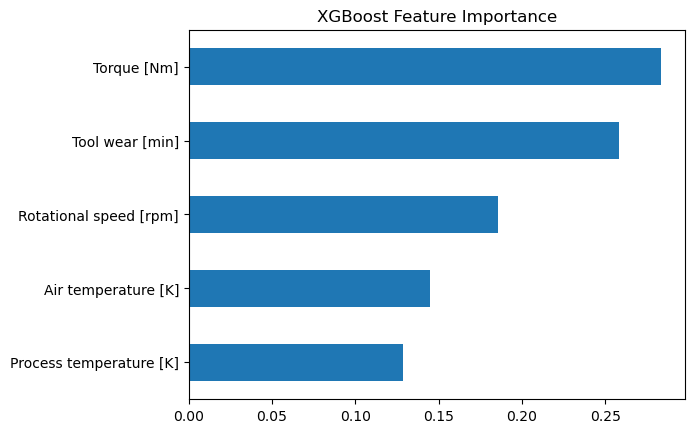

In [49]:
imp = pd.Series(xgb.feature_importances_, index=X.columns).sort_values()
imp.plot(kind="barh", title="XGBoost Feature Importance")
plt.show()

#
## Memilih best parameters untuk model
We're using RandomSearchCV for choosing the best parameters for our model

In [56]:
pipe_rf = Pipeline([
    ("scaler", StandardScaler()),
    ("smote", SMOTE(random_state=42, k_neighbors=3)),
    ("rf", RandomForestClassifier(random_state=42, class_weight="balanced"))
])

param_dist = {
    "smote__k_neighbors": [3, 5, 7],
    "rf__n_estimators": np.arange(300, 1001, 100),
    "rf__max_depth": [None, 8, 12, 16, 20],
    "rf__min_samples_split": [2, 5, 10, 20],
    "rf__min_samples_leaf": [1, 2, 4, 8],
    "rf__max_features": ["sqrt", "log2", None]
}

random_search = RandomizedSearchCV(
    estimator=pipe_rf,
    param_distributions=param_dist,
    n_iter=30,                  
    scoring="f1_macro",         
    cv=3,                       
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('smote',
                                              SMOTE(k_neighbors=3,
                                                    random_state=42)),
                                             ('rf',
                                              RandomForestClassifier(class_weight='balanced',
                                                                     random_state=42))]),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'rf__max_depth': [None, 8, 12, 16, 20],
                                        'rf__max_features': ['sqrt', 'log2',
                                                             None],
                                        'rf__min_samples_leaf': [1, 2, 4, 8],
                                        'rf__min_samples_split': [2, 5, 10, 20],
                                        'rf__n_estimators': array([ 300,  400,  500,  600,  700,  800,  900, 1000]),
                                        'smote__k_neighbors': [3, 5, 7]},
                   random_state=42, scoring='f1_macro', verbose=2)

In [59]:
print("Best params:", random_search.best_params_)
print("Best CV macro F1:", random_search.best_score_)

best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
print(" ")
print(classification_report(y_test, y_pred, zero_division=0))

Best params: {'smote__k_neighbors': 5, 'rf__n_estimators': 600, 'rf__min_samples_split': 5, 'rf__min_samples_leaf': 2, 'rf__max_features': 'sqrt', 'rf__max_depth': None}
Best CV macro F1: 0.5302544271985635
 
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1930
           1       0.04      0.11      0.06         9
           2       0.64      0.78      0.71        23
           3       0.78      0.78      0.78        18
           4       0.65      0.94      0.77        16
           5       0.00      0.00      0.00         4

    accuracy                           0.96      2000
   macro avg       0.52      0.60      0.55      2000
weighted avg       0.98      0.96      0.97      2000



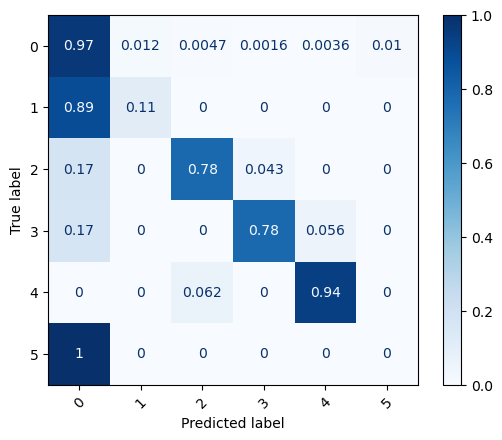

In [61]:
cm = confusion_matrix(y_test, y_pred, labels=best_model.classes_, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.show()

**Kesimpulan Model setelah Tuning**
1. Performa mayoritas (No Failure) tetap sangat kuat (recall tinggi).
2. Failure type yang punya pola jelas (HDF, PWF, OSF) → lumayan bagus (F1 sekitar 0.75–0.9).
3. TWF masih sulit → jumlah data terlalu kecil, recall rendah (0.11).
4. RNF (Random Failure) → gagal total → wajar, karena definisi RNF memang “acak”, dan datanya hanya 18 sample.

#
## Evaluation Final Model using Cross Validation
Cross Validation di sini merupakan proses validasi model (evaluasi, bukan training final).\
Tujuannya untuk mengukur kestabilan performa model di berbagai subset data, bukan hanya pada satu train-test split.\
Output mean dan std memberi gambaran:
* Mean → performa rata-rata model.
* Std → seberapa stabil performanya antar fold (semakin kecil semakin stabil).

In [65]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(best_model, X, y, cv=cv, scoring="f1_macro", n_jobs=-1)

print("CV macro F1 (5-fold):")
print(f"  mean = {scores.mean():.3f} | std = {scores.std():.3f}")
print("  per-fold =", [round(s,3) for s in scores])


CV macro F1 (5-fold):
  mean = 0.526 | std = 0.013
  per-fold = [0.519, 0.51, 0.548, 0.522, 0.531]


              precision    recall  f1-score   support

           0      0.991     0.963     0.977      9652
           1      0.061     0.196     0.093        46
           2      0.773     0.861     0.815       115
           3      0.578     0.813     0.676        91
           4      0.500     0.744     0.598        78
           5      0.000     0.000     0.000        18

    accuracy                          0.953     10000
   macro avg      0.484     0.596     0.526     10000
weighted avg      0.975     0.953     0.963     10000



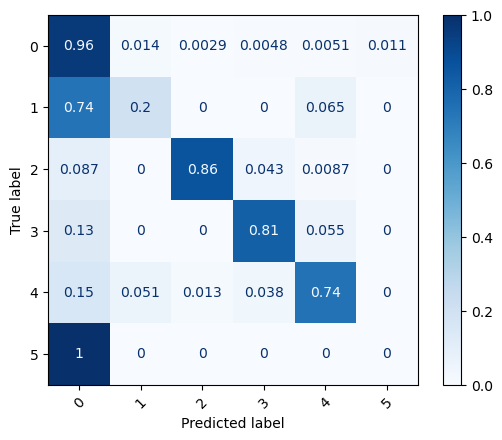

In [66]:
y_pred_cv = cross_val_predict(best_model, X, y, cv=cv, n_jobs=-1)

print(classification_report(y, y_pred_cv, digits=3, zero_division=0))

cm = confusion_matrix(y, y_pred_cv, labels=np.sort(y.unique()), normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.sort(y.unique()))
disp.plot(cmap="Blues", xticks_rotation=45)
plt.show()


#
## Save the Model

In [67]:
joblib.dump(best_model, "rf_failure_predictor.pkl")

['rf_failure_predictor.pkl']